# Проект: классификация

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [107]:
df = pd.read_csv('C:\\IDE\\data\\Project-4\\bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [109]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [110]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
print(df['job'].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [111]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].astype(str).apply(lambda x: x.split(','))
df['balance'] = df['balance'].apply(lambda x: x[0].replace(' ',''))
df['balance'] = df['balance'].apply(lambda x: 0 if x=='0$' else x)
df['balance'] = df['balance'].astype(float)

# Посмотрим среднее значение признака
print(round(df['balance'].mean(),3))

1529.129


### Задание 4

In [112]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
# Смотрим количество пропусков
print(df['balance'].isnull().sum())
# Заполняем медианным значением пропуски
df['balance'] = df['balance'].fillna(df['balance'].median())
# Еще раз выводи количетсво пропусков для проверки
print(df['balance'].isnull().sum())
# Смотрим среднее значение признака
print(round(df['balance'].mean(),3))

25
0
1526.936


### Задание 5

In [113]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
print(df['job'].describe())
print(df['education'].describe())

# Заменяем неявные пропуски на модальное значение признака
df['job'] = df['job'].apply(lambda x: 'management' if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: 'secondary' if x=='unknown' else x)

print('-'*40)
print(df['job'].unique())
print(df['education'].unique())

# Находим средний баланс по самым популярным значением работы и образования
filtered_df = df[((df['job'] == 'management') & (df['education'] == 'secondary'))]
print('-'*40)
print(round(filtered_df['balance'].mean(),3))

count          11162
unique            12
top       management
freq            2566
Name: job, dtype: object
count         11162
unique            4
top       secondary
freq           5476
Name: education, dtype: object
----------------------------------------
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']
['secondary' 'tertiary' 'primary']
----------------------------------------
1598.883


### Задание 6

Нижняя граница по методу Тьюки: -2241
Верхняя граница по методу Тьюки: 4063
Результирующее число записей: 10105


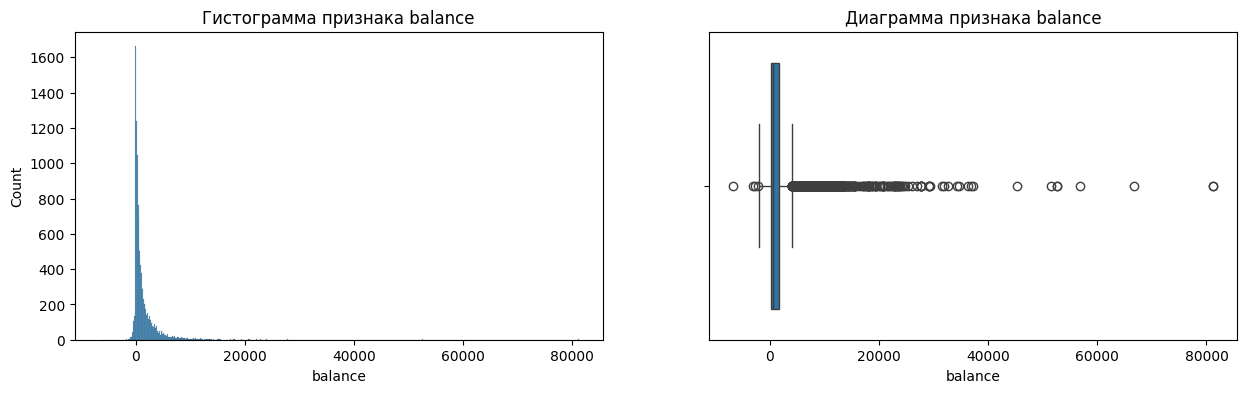

In [114]:
# удалите все выбросы для признака balance
# ваш код

# Строим гистограмму и коробчатую диаграмму распределения признака баланса клиентов
fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(15,4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0])
histplot.set_title("Гистограмма признака balance")
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1])
boxplot.set_title("Диаграмма признака balance")

# Пишем функция для определения выбросов методом Тьюки
def outliers_igr(data, feature):
    """Функция вычисляет границы распределния признака для очистки от выбросов

    Args:
        data (DataFrame): Датасет
        feature (Series): Нужный признак для очистки от выбросов

    Returns:
        Series: Возвращает два обьекта в которых храняться отброшенные и очищенные данные
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    igr = quartile_3-quartile_1
    lower_bound = quartile_1-(igr*1.5)
    print(f'Нижняя граница по методу Тьюки: {round(lower_bound)}')
    upper_bound = quartile_3+(igr*1.5)
    print(f'Верхняя граница по методу Тьюки: {round(upper_bound)}')
    outliers = data[(x<lower_bound)|(x>upper_bound)]
    cleaned = data[(x>=lower_bound)&(x<=upper_bound)]
    return outliers, cleaned

outliers, cleaned_df = outliers_igr(df, 'balance')
print(f'Результирующее число записей: {cleaned_df.shape[0]}')

## Часть 2:  Разведывательный анализ

In [115]:
print(cleaned_df.shape)
display(cleaned_df)

(10105, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


### Задание 1

Число клиентов открывших депозит: 4681
Число клиентов не открывших депозит: 5424


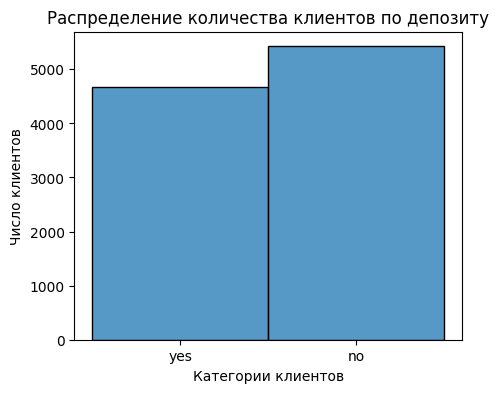

In [116]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
print("Число клиентов открывших депозит: {}".format(cleaned_df[cleaned_df['deposit']=='yes'].shape[0]))
print("Число клиентов не открывших депозит: {}".format(cleaned_df[cleaned_df['deposit']=='no'].shape[0]))

plt.figure(figsize=(5,4))
plt.title('Распределение количества клиентов по депозиту')
plt.xlabel('Категории клиентов')
plt.ylabel('Число клиентов')
sns.histplot(data=cleaned_df, x='deposit');

### Задания 2 и 3

Максимальный возраст среди клиентов банка: 95
Минимальное время общение с клиентом банка: 2


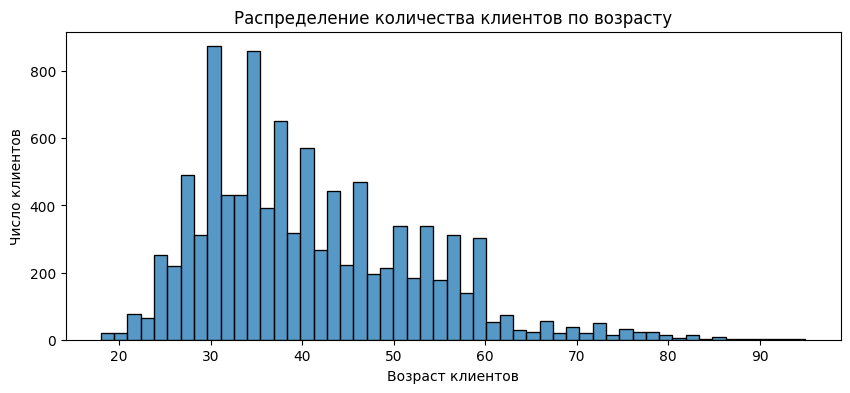

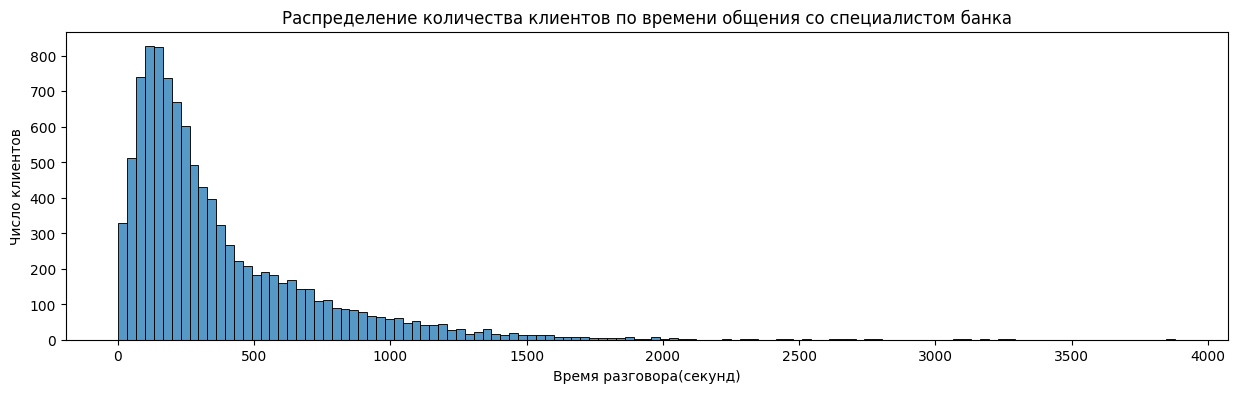

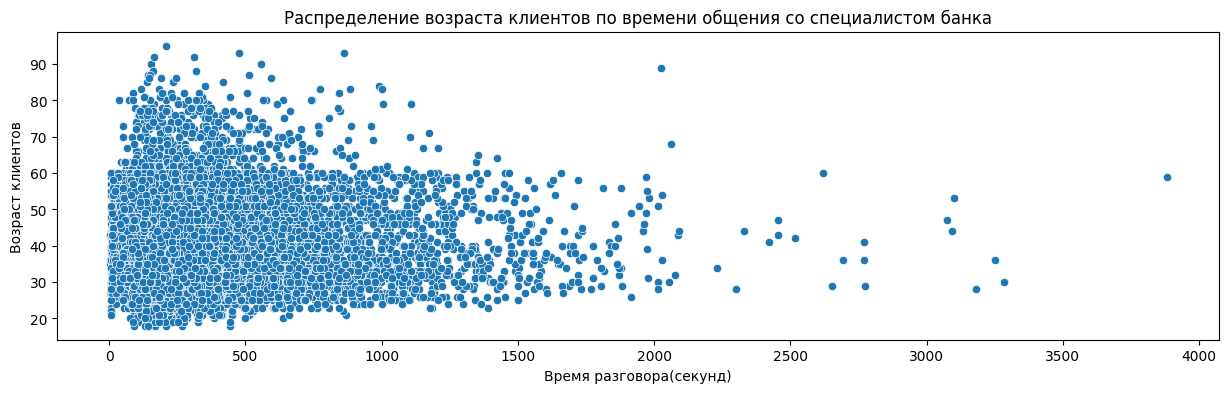

In [117]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

print('Максимальный возраст среди клиентов банка: {}'.format(cleaned_df['age'].max()))
print('Минимальное время общение с клиентом банка: {}'.format(cleaned_df['duration'].min()))

plt.figure(figsize=(10,4))
plt.title('Распределение количества клиентов по возрасту')
plt.xlabel('Возраст клиентов')
plt.ylabel('Число клиентов')
sns.histplot(data=cleaned_df, x='age');

plt.figure(figsize=(15,4))
plt.title('Распределение количества клиентов по времени общения со специалистом банка')
plt.xlabel('Время разговора(секунд)')
plt.ylabel('Число клиентов')
sns.histplot(data=cleaned_df, x='duration');

plt.figure(figsize=(15,4))
plt.title('Распределение возраста клиентов по времени общения со специалистом банка')
plt.xlabel('Время разговора(секунд)')
plt.ylabel('Возраст клиентов')
sns.scatterplot(data=cleaned_df, x='duration', y='age');

Как видно из графиков, большиство клиентов имеют возраст от 30 до 40 лет.
По большей части клиенты тратят менее 8 минут на общение с сотрудниками банка.
В не зависимости от возраста, клиенты не ведут продолжительные разговоры с сотрудниками банка.


### Задания 4 и 5

,campaign
month,
apr,1520
aug,4892
dec,195
feb,1512
jan,547
jul,4692
jun,3178
mar,470
may,6056


11


<Axes: title={'center': 'График количества клиентов в зависимости от профессии'}, xlabel='Название профессии', ylabel='Количество'>

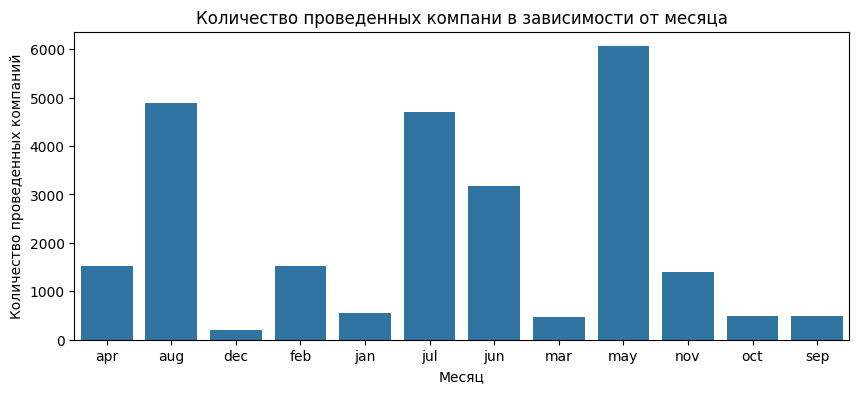

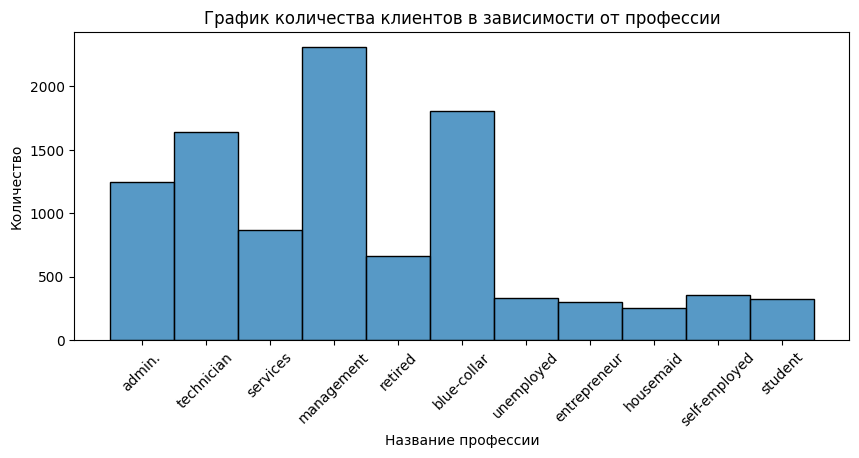

In [118]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код

# Группируем данные по месяцам чтоы посмотреть количество проведенных компаний
marketing_compaign_data = cleaned_df.groupby(by='month')[['campaign']].sum()
display(marketing_compaign_data)
# Посмотрим на число профессий клиентов банка
print(len(cleaned_df['job'].unique()))

#постройте визуализации, иллюстрирующие результаты

# График числа компаний по месяцам
plt.figure(figsize=(10,4))
plt.title('Количество проведенных компани в зависимости от месяца')
plt.xlabel('Месяц')
plt.ylabel('Количество проведенных компаний')
sns.barplot(data=marketing_compaign_data, x='month', y='campaign')
# График распределения числа клиентов по профессиям
plt.figure(figsize=(10,4))
plt.title('График количества клиентов в зависимости от профессии')
plt.xlabel('Название профессии')
plt.xticks(rotation=45)
plt.ylabel('Количество')
sns.histplot(data=cleaned_df, x='job')

### Задание 6

In [119]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
previous_campaign_df = cleaned_df.groupby(by='poutcome')[['deposit']].value_counts()
display(previous_campaign_df)

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64

In [120]:
display(cleaned_df['poutcome'].value_counts())

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

### Задание 7

In [121]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

# Список с уникальными названиями месяцов
month_list = cleaned_df['month'].unique()
# Пустой список для хранения процентного значения
month_percent = list()


def get_month_failure(month_list, cleaned_df):
    """Функция возвращает новый датафрейм с интересующими нас показателями

    Args:
        month_list (list): Список с названиями месяцов
        cleaned_df (DataFrame): Наши данные

    Returns:
        DataFrame: Новый DataFrame с процентным показателем отказа от депозита по месяцам
    """
    for i in month_list:
       x = (cleaned_df[(cleaned_df['month']==i)&(cleaned_df['poutcome']=='failure')].shape[0] / cleaned_df[(cleaned_df['month']==i)&(cleaned_df['poutcome']!='unknown')].shape[0])*100
       month_percent.append(x)
    month_failure = pd.DataFrame({'month': month_list, 'failure_percent': month_percent})
    return month_failure

get_month_failure(month_list, cleaned_df)

,month,failure_percent
0,may,59.292035
1,jun,30.000000
2,jul,31.818182
3,aug,32.684825
4,oct,36.046512
5,nov,52.651515
6,dec,21.568627
7,jan,34.821429
8,feb,46.181818
9,mar,29.545455


### Задание 8

In [122]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_cat(feature):
    """Функция преобразующая числовой признак возраста в категориальный

    Args:
        feature (_Series_): _Числовой признак возраста_

    Returns:
        _type(str)_: _Возвращает строковое значение для категориального признака_
    """
    if feature < 30:
        return '<30'
    elif 30<=feature<=40:
        return '30-40'
    elif 40<feature<=50:
        return '40-50'
    elif 50<feature<=60:
        return '50-60'
    elif feature > 60:
            return '60+'
        
cleaned_df['age_cat'] = cleaned_df['age'].apply(get_age_cat)

# Группируем таблицу по новому признаку
age_cat_df = cleaned_df.groupby(by=['age_cat'], as_index=False).value_counts()
# Создаем вспомогательные таблицы с разделением по депозиту
deposit_yes = age_cat_df[age_cat_df['deposit']=='yes']
deposit_no = age_cat_df[age_cat_df['deposit']=='no']

# Выводим разницу для между положительным и отрицательным значением числа открывших депозит клиентов
display(deposit_yes['age_cat'].value_counts()-deposit_no['age_cat'].value_counts())

age_cat
30-40   -623
40-50   -465
50-60   -241
60+      319
<30      267
Name: count, dtype: int64

### Задания 9 и 10

In [123]:
display(deposit_yes)

,age_cat,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,count
1,30-40,30,admin.,divorced,secondary,no,10.0,yes,no,cellular,18,jul,658,2,-1,0,unknown,yes,1
4,30-40,30,admin.,divorced,secondary,no,377.0,yes,no,unknown,4,jun,524,15,-1,0,unknown,yes,1
7,30-40,30,admin.,married,secondary,no,0.0,no,no,cellular,1,jun,318,1,-1,0,unknown,yes,1
13,30-40,30,admin.,married,secondary,no,396.0,yes,no,cellular,13,may,366,3,348,2,failure,yes,1
18,30-40,30,admin.,married,secondary,no,873.0,yes,no,unknown,29,may,792,3,-1,0,unknown,yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10097,<30,29,unemployed,single,secondary,no,1055.0,no,no,cellular,23,sep,427,1,603,1,failure,yes,1
10098,<30,29,unemployed,single,secondary,no,1584.0,no,no,cellular,6,sep,245,1,-1,0,unknown,yes,1
10101,<30,29,unemployed,single,tertiary,no,70.0,no,no,cellular,25,may,393,1,-1,0,unknown,yes,1
10103,<30,29,unemployed,single,tertiary,no,497.0,yes,no,cellular,18,may,642,3,298,6,success,yes,1


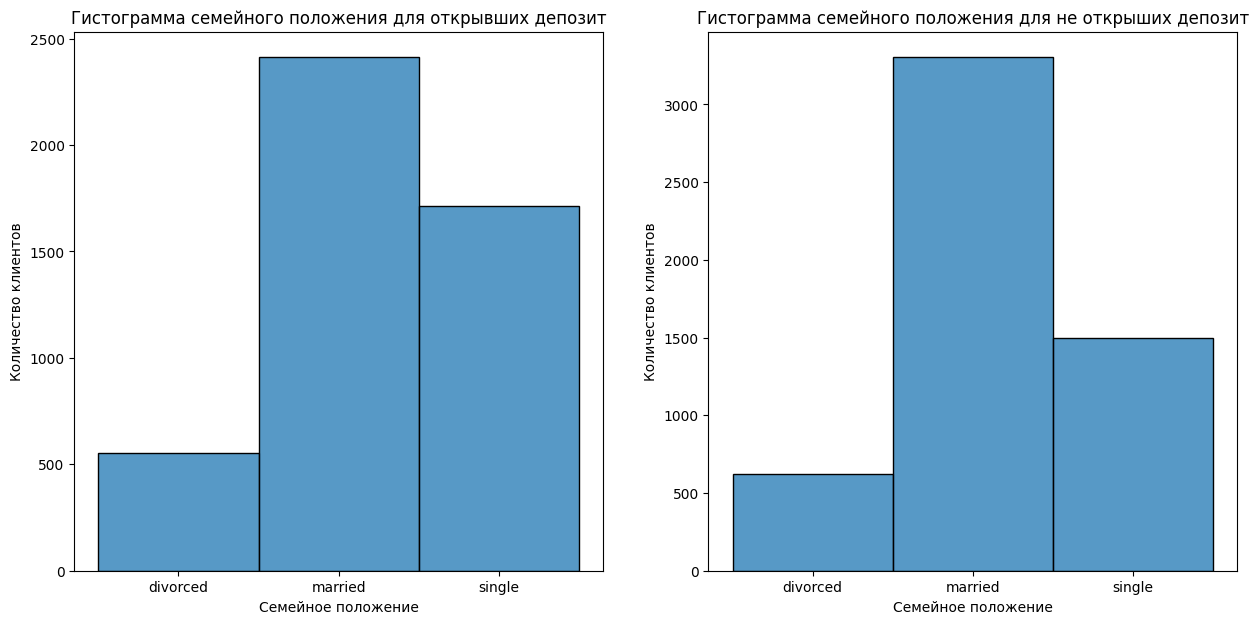

In [124]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(15,7))
histplot = sns.histplot(data=deposit_yes, x='marital', ax=axes[0])
histplot.set_title("Гистограмма семейного положения для открывших депозит")
histplot.set_xlabel("Семейное положение")
histplot.set_ylabel("Количество клиентов")
histplot = sns.histplot(data=deposit_no, x='marital', ax=axes[1])
histplot.set_title("Гистограмма семейного положения для не открыших депозит")
histplot.set_xlabel("Семейное положение")
histplot.set_ylabel("Количество клиентов");

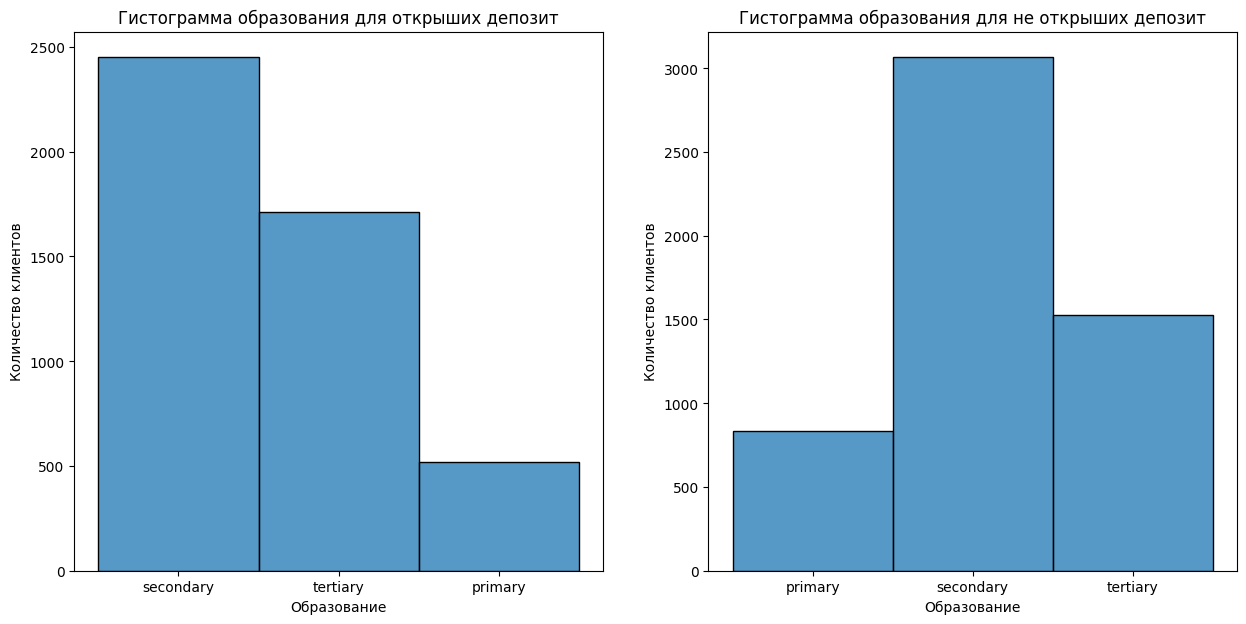

In [166]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(15,7))
histplot = sns.histplot(data=deposit_yes, x='education', ax=axes[0])
histplot.set_title("Гистограмма образования для открыших депозит")
histplot.set_xlabel("Образование")
histplot.set_ylabel("Количество клиентов")
histplot = sns.histplot(data=deposit_no, x='education', ax=axes[1])
histplot.set_title("Гистограмма образования для не открыших депозит")
histplot.set_xlabel("Образование")
histplot.set_ylabel("Количество клиентов");


In [126]:
deposit_yes['job'].unique()

array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'self-employed', 'services', 'student', 'technician', 'unemployed',
       'retired'], dtype=object)

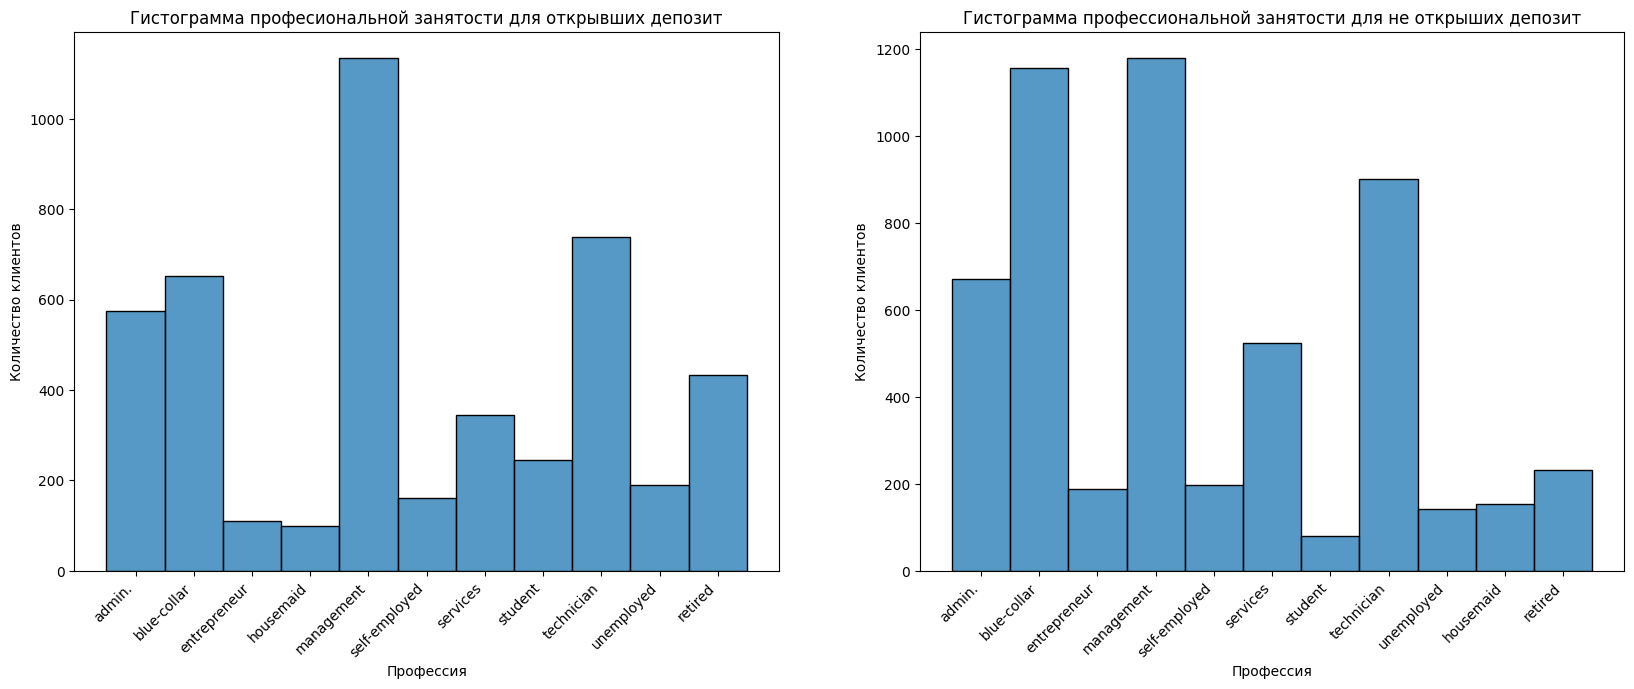

In [127]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

fig, (ax1, ax2) =plt.subplots(nrows=1, ncols=2, figsize=(20,7))
histplot = sns.histplot(data=deposit_yes, x='job', ax=ax1)
histplot.set_title("Гистограмма професиональной занятости для открывших депозит")
histplot.set_xlabel("Профессия")
histplot.set_ylabel("Количество клиентов")
ax1.set_xticklabels(deposit_yes['job'].unique(), rotation=45, ha='right')
histplot = sns.histplot(data=deposit_no, x='job', ax=ax2)
histplot.set_title("Гистограмма профессиональной занятости для не открыших депозит")
histplot.set_xlabel("Профессия")
histplot.set_ylabel("Количество клиентов")
ax2.set_xticklabels(deposit_no['job'].unique(), rotation=45, ha='right');

### Задание 11

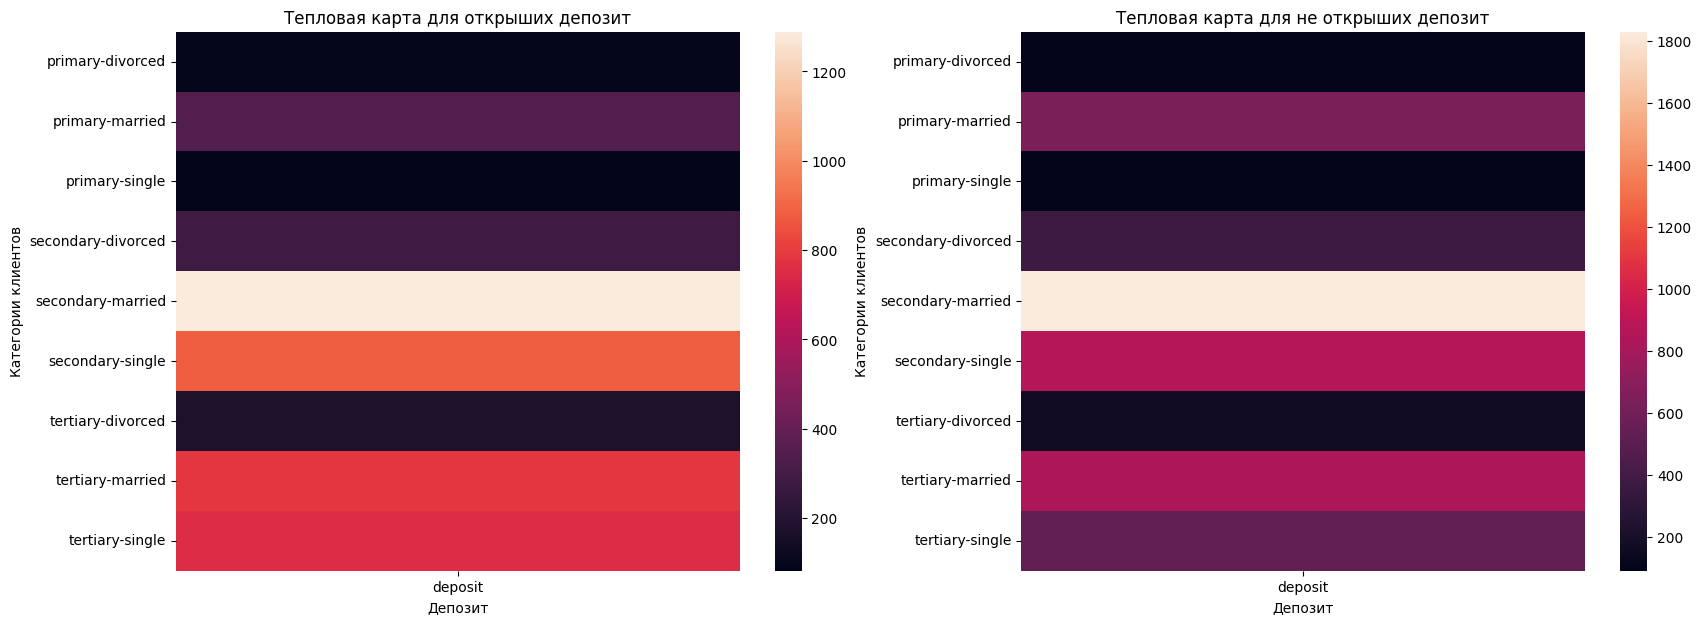

In [170]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

deposit_yes = cleaned_df[cleaned_df['deposit']=='yes']
pt_yes = pd.pivot_table(data=deposit_yes, index=['education', 'marital'],values='deposit',aggfunc='count')

deposit_no = cleaned_df[cleaned_df['deposit']=='no']
pt_no = pd.pivot_table(data=deposit_no, index=['education', 'marital'],values='deposit',aggfunc='count')

fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(20,7))
histplot = sns.heatmap(data=pt_yes, ax=axes[0])
histplot.set_title("Тепловая карта для открыших депозит")
histplot.set_xlabel("Депозит")
histplot.set_ylabel("Категории клиентов")
histplot = sns.heatmap(data=pt_no, ax=axes[1])
histplot.set_title("Тепловая карта для не открыших депозит")
histplot.set_xlabel("Депозит")
histplot.set_ylabel("Категории клиентов");


## Часть 3: преобразование данных

### Задание 1

In [174]:
# преобразуйте уровни образования
# Используем метод LabelEncoder без дополнительных настроек согласно заданию
le = LabelEncoder()
cleaned_df['education_encoded'] = le.fit_transform(cleaned_df['education'])
# Посмотрим сумму значений закодированного признака
print(cleaned_df['education_encoded'].sum())
cleaned_df['age_cat_encoded'] = le.fit_transform(cleaned_df['age_cat'])
cleaned_df.head()

11995


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_cat,education_encoded,age_cat_encoded
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60,1,2
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60,1,2
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50,1,1
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60,1,2
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60,2,2


### Задания 2 и 3

In [130]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [131]:
# создайте дамми-переменные

### Задания 5 и 6

In [132]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [133]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [134]:
# рассчитайте необходимые показатели

### Задание 9

In [135]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [136]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [137]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [138]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [139]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [140]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [141]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [142]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [143]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [144]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna